In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pyvista as pv
import numpy as np
import scipy.linalg as la

np.set_printoptions(formatter={"float": "{:10.2f}".format})

mesh_path = "../tmp/INRIA_MUSIS.stl"
mesh = pv.read(mesh_path)

In [4]:
from src.dmcpworkflow.capture_depth import generate_depth_map

imIm, imK, imP = generate_depth_map(mesh_path)

transform_matrix = np.array([[1, 0, 0, 0],
                             [0, 1, 0, 0],
                             [0, 0, 1, 0],
                             [0, 0, 0, 1]])

imP = imP @ la.inv(transform_matrix)

pos = la.null_space(imP) / la.null_space(imP)[-1]
print(f"position \n{pos}")


position 
[[   6722.14]
 [  12345.64]
 [  10572.14]
 [      1.00]]


In [5]:
from src.dmcpworkflow.capture_depth import generate_depth_map

dmIm, dmK, dmP = generate_depth_map(mesh_path)
pos = la.null_space(dmP) / la.null_space(dmP)[-1]
print(f"position \n{pos}")

position 
[[   6722.14]
 [  12345.64]
 [  10572.14]
 [      1.00]]


In [6]:
from src.dmcpworkflow.annotate_points import annotate

%matplotlib
cps = annotate(imIm,dmIm)
%matplotlib inline
cps_annotated = cps.copy()
cps[:,2:] = cps[:,:2]

Using matplotlib backend: <object object at 0x7fb3e025d160>


visualize cps

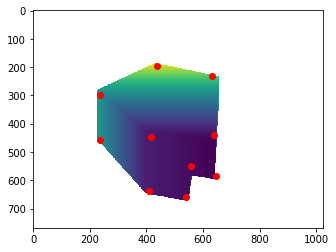

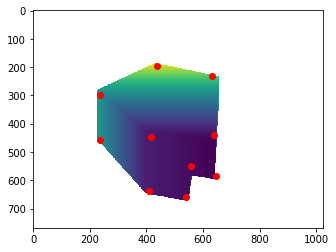

In [7]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(imIm)
plt.scatter(cps[:,0],cps[:,1],c="r")

plt.figure()
plt.imshow(dmIm)
plt.scatter(cps[:,2],cps[:,3],c="r")

plt.show()

In [8]:
from src.pycv.dmcp import dm_to_world, dmcp

im_pts_world = dm_to_world(imIm, imK, imP, cps[:,:2])
world_pts = dm_to_world(dmIm, dmK, dmP, cps[:,2:])

print(f"{im_pts_world}\n\n{world_pts}")

[[   -136.43    3990.48    2038.88]
 [  -1688.62    5860.33    2306.68]
 [  -1572.76    6032.22     415.34]
 [  -1024.89    5284.11     781.05]
 [   -921.92    5136.36    -767.93]
 [    -95.82    3932.13    -751.12]
 [      1.55     363.48    -105.65]
 [      2.31     309.30    2760.55]
 [  -3479.17     490.77    3509.61]
 [  -4902.26    3265.35    3277.92]]

[[   -136.43    3990.48    2038.88]
 [  -1688.62    5860.33    2306.68]
 [  -1572.76    6032.22     415.34]
 [  -1024.89    5284.11     781.05]
 [   -921.92    5136.36    -767.93]
 [    -95.82    3932.13    -751.12]
 [      1.55     363.48    -105.65]
 [      2.31     309.30    2760.55]
 [  -3479.17     490.77    3509.61]
 [  -4902.26    3265.35    3277.92]]


In [9]:
# overlay world points and mesh to verify correctness

_mPtsIm = pv.PolyData(im_pts_world)
_mPts = pv.PolyData(world_pts)

pl = pv.Plotter()
pl.add_mesh(mesh)
pl.add_mesh(_mPtsIm,color="green")
pl.add_mesh(_mPts,color="red")
pl.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

result: not perfect but also not completely wrong

probably the depth map does not correspond directly to the captured projection matrix 

In [12]:
from src.pycv.dmcp import solve_PnP, dmcp

A = dmcp(imK, imP, cps[:,:2], world_pts)
A


estimated pose
[[     -0.75       0.36      -0.55    5217.82]
 [      0.66       0.38      -0.65   12094.40]
 [     -0.03      -0.85      -0.52    8983.76]]


array([[      0.94,      -0.06,      -0.34,     122.26],
       [     -0.02,       0.97,      -0.24,    -270.11],
       [      0.34,       0.23,       0.91,   -1348.36],
       [      0.00,       0.00,       0.00,       1.00]])

position of P_trans
[[   2107.69]
 [   8998.44]
 [  13467.98]
 [      1.00]]


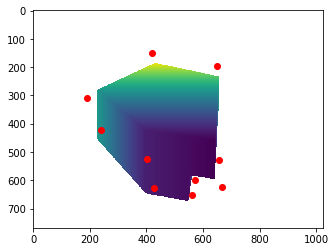

In [13]:

P_trans = imP @ la.inv(A)

p_trans_pos = la.null_space(P_trans) / la.null_space(P_trans)[-1]
print(f"position of P_trans\n{p_trans_pos}")

p_world_hat = np.hstack((world_pts,np.ones((world_pts.shape[0], 1))))
reprojs = P_trans @ p_world_hat.T
reprojs = reprojs.T
reprojs = np.array([ reprojs[:,0] / reprojs[:,-1], reprojs[:,1] / reprojs[:,-1]  ]).T

plt.imshow(imIm, origin="upper")
plt.scatter(reprojs[:,0],reprojs[:,1],color="red")